## Compare SOM output with zotbin

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pwd

/global/u2/b/belaa/lsst/repos/pz_bayes/notebooks


In [3]:
import sys
sys.path = ['/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge'] + sys.path

In [4]:
import time
import pathlib
from scipy.optimize import curve_fit
from somviz import som
import jax_cosmo
import tomo_challenge as tc
import seaborn as sns
import pandas as pd
import zotbin.binned as binned
import zotbin.group as group
from zotbin.group import plotfbins
from zotbin.flow import learn_flow
from zotbin.util import prepare, get_signature

sns.set()

Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [5]:
data_path = pathlib.Path('/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge')
dc2_path = data_path / 'data/training.hdf5'
buzzard_path = data_path / 'data_buzzard/training.hdf5'

#### Load the data

In [6]:
bands = 'griz'
include_errors = False
include_colors = False

dc2_train = tc.load_data(dc2_path, bands, errors=include_errors, colors=include_colors, array=True)
buzzard_train = tc.load_data(buzzard_path, bands, errors=include_errors, colors=include_colors, array=True)

dc2_train_z = tc.load_redshift(dc2_path)
buzzard_train_z = tc.load_redshift(buzzard_path)

/global/cscratch1/sd/belaa/lsst/repos/tomo_challenge/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


#### See what they look like

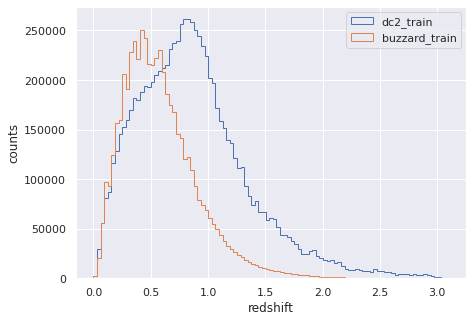

In [7]:
plt.figure(figsize=(7,5))
plt.hist(dc2_train_z, bins=np.linspace(0,3.1,100), histtype='step', label='dc2_train')
plt.hist(buzzard_train_z, bins=np.linspace(0,3.1,100), histtype='step', label='buzzard_train')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('counts');

In [8]:
def make_df(data, z, bands=bands):
    df = pd.DataFrame(data, columns=list(bands))
    df['redshift'] = z
    return(df)

def bin_percentiles(data, z, nzbins=10, bands=bands):
    df = make_df(data, z, bands)
    zbins = np.percentile(df['redshift'], np.linspace(0, 100, nzbins + 1))
    zbins[-1] += 1
    iz = np.digitize(df['redshift'], zbins) - 1
    assert np.all((iz >= 0) & (iz < nzbins))
    df['iz'] = iz
    return(df)

def make_pairplot(data, z, nzbins=10, bands=bands, thin=2000):
    df = bin_percentiles(data, z, nzbins=10, bands=bands)
    sns.pairplot(df[::thin], vars=list(bands) + ['redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

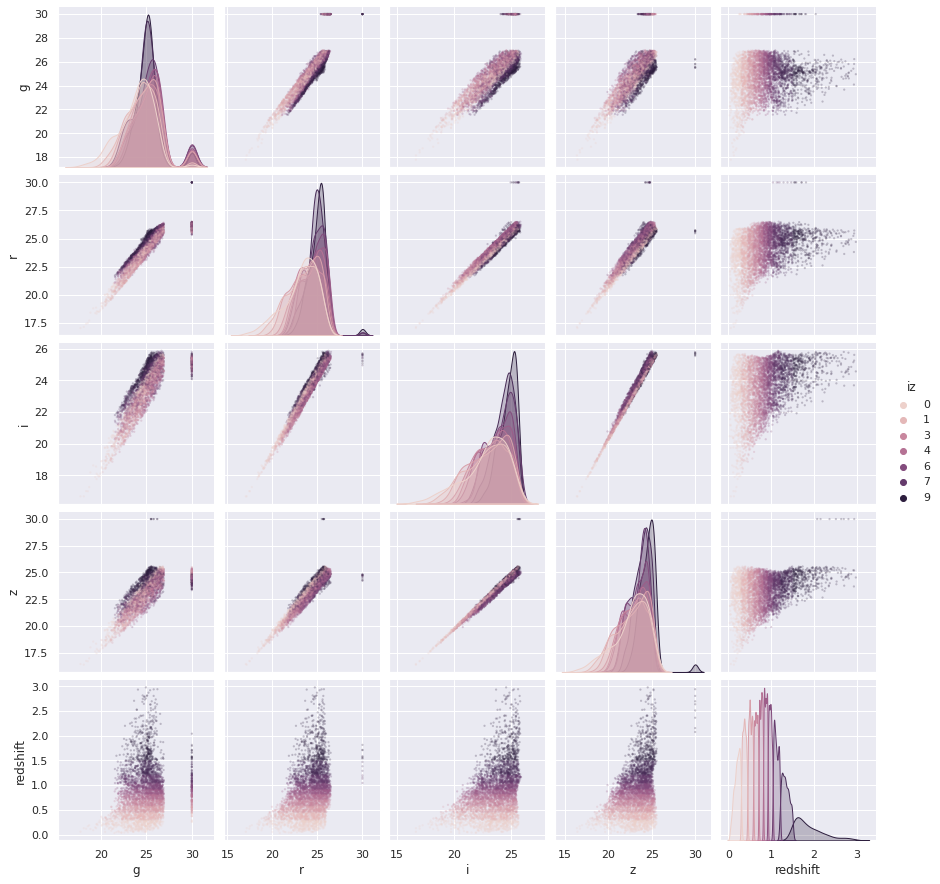

In [10]:
make_pairplot(dc2_train, dc2_train_z)

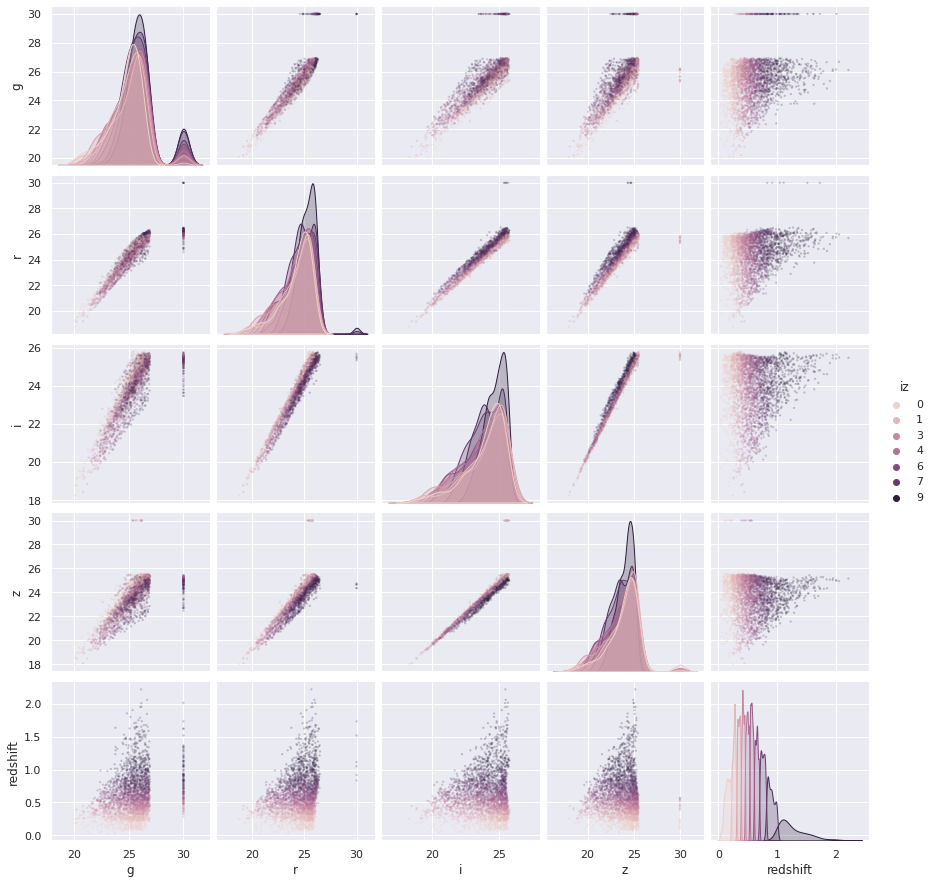

In [11]:
make_pairplot(buzzard_train, buzzard_train_z)

#### Prepare data

In [7]:
# from: https://github.com/dkirkby/zotbin/blob/master/zotbin/util.py

def prepare(data, bands, feature_mode='i'):
    """Prepare features from input data and flag galaxies with undetected flux.
    """
    if data.shape[1] != len(bands):
        raise ValueError(f'data has {data.shape[1]} columns but expected {len(bands)} for {bands}.')
    # Flag any galaxies with undetected flux.
    detected = np.all((data != 30) & np.isfinite(data), axis=1)
    print(f'Found {np.count_nonzero(~detected)} galaxies with undetected flux in at least one band.')
        
    if feature_mode in 'griz':
        # Use colors plus one flux as the input features.
        colors = np.diff(data, axis=1)
        idx = bands.index(feature_mode)
        flux = data[:, idx:idx+1]
        features = np.concatenate((colors, flux), axis=1)
        return features, detected
        
    if feature_mode == 'triplets':
        df = pd.DataFrame()
        # colors
        for i in range(len(bands)-1):
            for j in range(i+1, len(bands)):
                col = f'{bands[i]}-{bands[j]}'
                df[col] = data[:,i] - data[:,j]

        # triplets
        for i in range(len(bands)-2):
            color1 = f'{bands[i]}-{bands[i+1]}'
            color2 = f'{bands[i+1]}-{bands[i+2]}'
            col = f'{color1}-({color2})'
            df[col] = df[color1] - df[color2]

        # z flux
        col = 'z'
        df[col] = data[:,-1]
        return(df.to_numpy(), detected)

#### Train on `griz`: g-r, r-i, i-z, i

In [10]:
features, detected = prepare(dc2_train, bands, feature_mode='i')
features = features[detected]
redshifts = dc2_train_z[detected]

Found 491827 galaxies with undetected flux in at least one band.


#### Look at how SOM time scales with different parameter settings

In [13]:
def scale(features, redshifts, values=np.arange(5,40,5), param='nside'):
    
    nside = 5
    niter = 5
    thin = 100
    X = features[::thin]
    Y = redshifts[::thin]
    tt = np.empty(len(values))
    for i, val in enumerate(values):
        start = time.time()
        if param == 'nside':
            som_train = som.SelfOrganizingMap(som.Grid(val, val))
            som_train.fit(X, Y, maxiter=niter)
        if param == 'niter':
            som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
            som_train.fit(X, Y, maxiter=val)
        if param == 'thin':
            X = features[::val]
            Y = redshifts[::val]
            som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
            som_train.fit(X, Y, maxiter=niter)
        tt[i] = (time.time() - start)
    return(tt)

In [51]:
nside_times = scale(features, redshifts)
niter_times = scale(features, redshifts, param='niter')
thin_times = scale(features, redshifts, param='thin')

/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


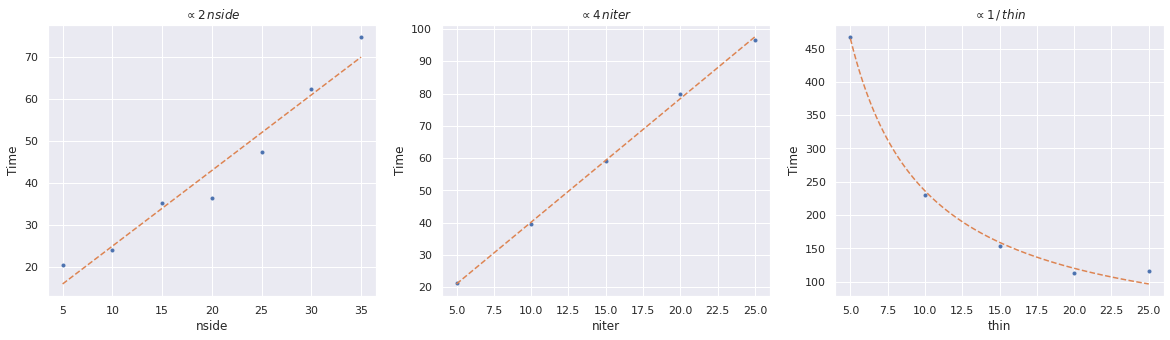

In [220]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = axs.ravel()

xp = np.linspace(5,35,100)
values = np.arange(5,40,5)
axs[0].plot(values, nside_times, '.')
nside_pred = np.poly1d(np.polyfit(values, nside_times, 1))
axs[0].plot(xp, nside_pred(xp), '--')
axs[0].set_title(rf'$\propto {nside_pred[1]:0.0f}\,nside$')
axs[0].set_xlabel('nside')
axs[0].set_ylabel('Time')

xp = np.linspace(5,25,100)
axs[1].plot([5, 10, 15, 20, 25], niter_times, '.')
niter_pred = np.poly1d(np.polyfit(np.arange(5,30,5), niter_times, 1))
axs[1].plot(xp, niter_pred(xp), '--')
axs[1].set_title(rf'$\propto {niter_pred[1]:0.0f}\,niter$')
axs[1].set_xlabel('niter')
axs[1].set_ylabel('Time')

def power_law(x, a, b):
    return a*np.power(x, b)
pars, cov = curve_fit(f=power_law, xdata=np.arange(5,30,5), ydata=thin_times, p0=[0, 0], bounds=(-np.inf, np.inf))

axs[2].plot([5, 10, 15, 20, 25], thin_times, '.')
axs[2].plot(xp, power_law(xp, *pars), '--')
#axs[2].set_title(rf'$\propto n^{pars[1]:.2f}$')
axs[2].set_title(rf'$\propto 1 \, / \,thin$')
axs[2].set_xlabel('thin')
axs[2].set_ylabel('Time');

#### Make SOM

In [ ]:
nside = -20
niter = 50

In [55]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
som_train.fit(X, Y, maxiter=niter)
print(time.time() - start)

3410.385278224945


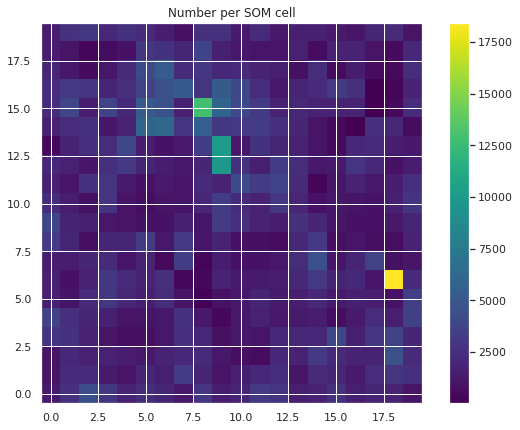

In [58]:
som_train.plot_counts_per_cell()

In [59]:
# No non-empty cells
np.min(som_train._counts), Y.max()

(5, 3.0358972549438477)

In [60]:
# from: https://github.com/dkirkby/zotbin/blob/master/zotbin/group.py

def plotzgrp(zhist, zedges=None, stretch=4, sort=False, figsize=(10,5)):
    ngrp, nzbin = zhist.shape
    if zedges is None:
        zc = np.arange(nzbin)
    else:
        zc = 0.5 * (zedges[1:] + zedges[:-1])
    zplot = zhist / zhist.max(axis=1, keepdims=True)
    if sort:
        zavg = np.sum(zhist * np.arange(nzbin), axis=1) / np.sum(zhist, axis=1)
        zplot = zplot[np.argsort(zavg)]
    fig = plt.figure(figsize=figsize)
    yoffsets = np.arange(ngrp) / stretch
    for dndz, dy in zip(zplot[::-1], yoffsets[::-1]):
        #plt.plot(zc, dndz + dy, 'r-', alpha=0.5)
        plt.fill_between(zc, dndz + dy, dy, facecolor=(1, 1, 1, 0.75), edgecolor=(1, 0, 0, 0.5), lw=1)
    plt.gca().axis('off')
    plt.tight_layout()

In [ ]:
ngrp = nside ** 2
nzbin = 80

zedges = binned.get_zedges(zmax=3, nzbin=nzbin)

In [61]:
zhist = np.empty((ngrp,nzbin))

for i in range(ngrp):
    zhist[i], _ = np.histogram(som_train._target_dist[i], bins=nzbin)

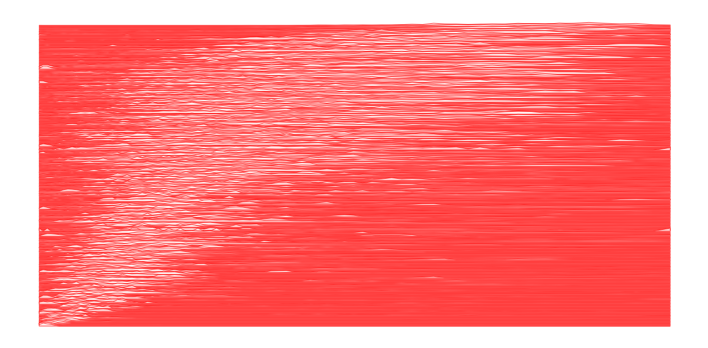

In [62]:
group.plotzgrp(zhist, zedges, sort=True)

### Group bins with zotbin

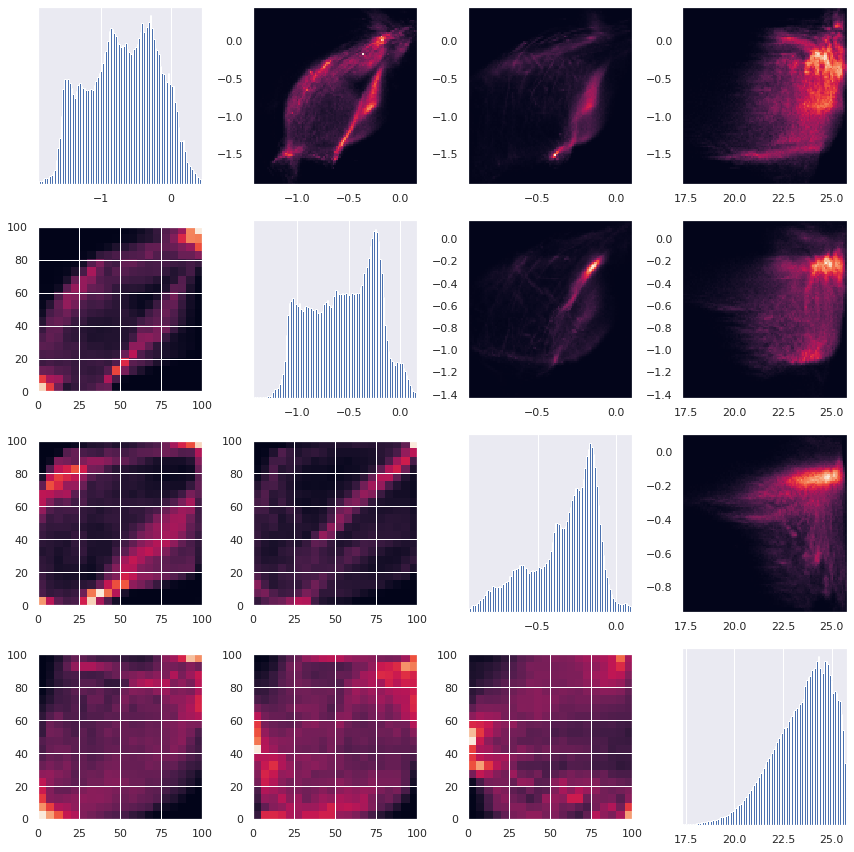

In [12]:
plotfbins(X, inset_pct=0.1, show_edges=False)

### Calculate flows

In [233]:
def get_flows(X, Y):
    # Time processing
    start = time.time()
    signature = get_signature(X)
    pname = pathlib.Path('preprocessed_{0}.npy'.format(signature))
    if pname.exists():
        U = np.load(pname)
    else:
        flow_map = learn_flow(data[:400000], interval=25)
        U = flow_map(X)
        np.save(f'preprocessed_{signature}.npy', U)
    assert U.shape == X.shape
    print(f'Finished in {time.time() - start} seconds')
    return(U, X, Y)

Don't use `bands`, use the data that was already prepared in the SOM section:

In [234]:
U_dc2, X_dc2, Y_dc2 = get_flows(X, Y)

Finished in 0.38785386085510254 seconds


ValueError: supplied range of [nan, nan] is not finite

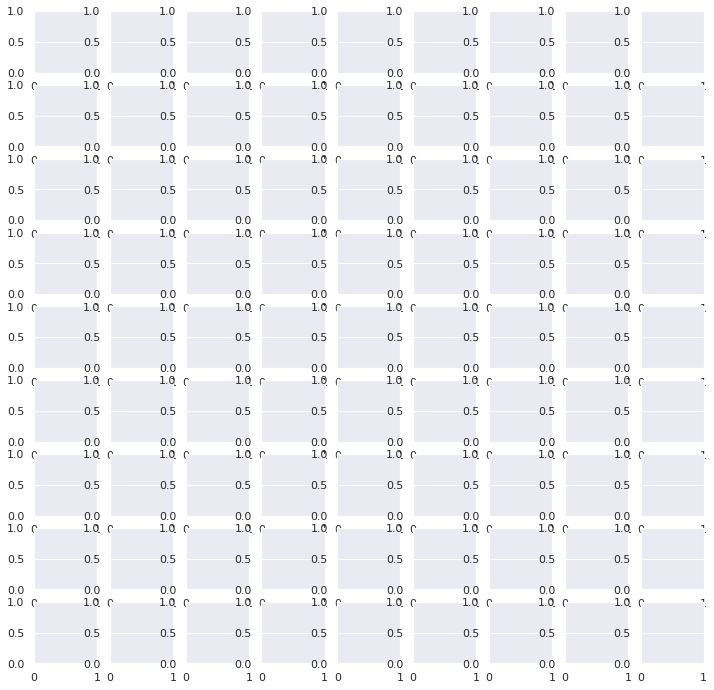

In [235]:
plotfbins(U_dc2, inset_pct=0)

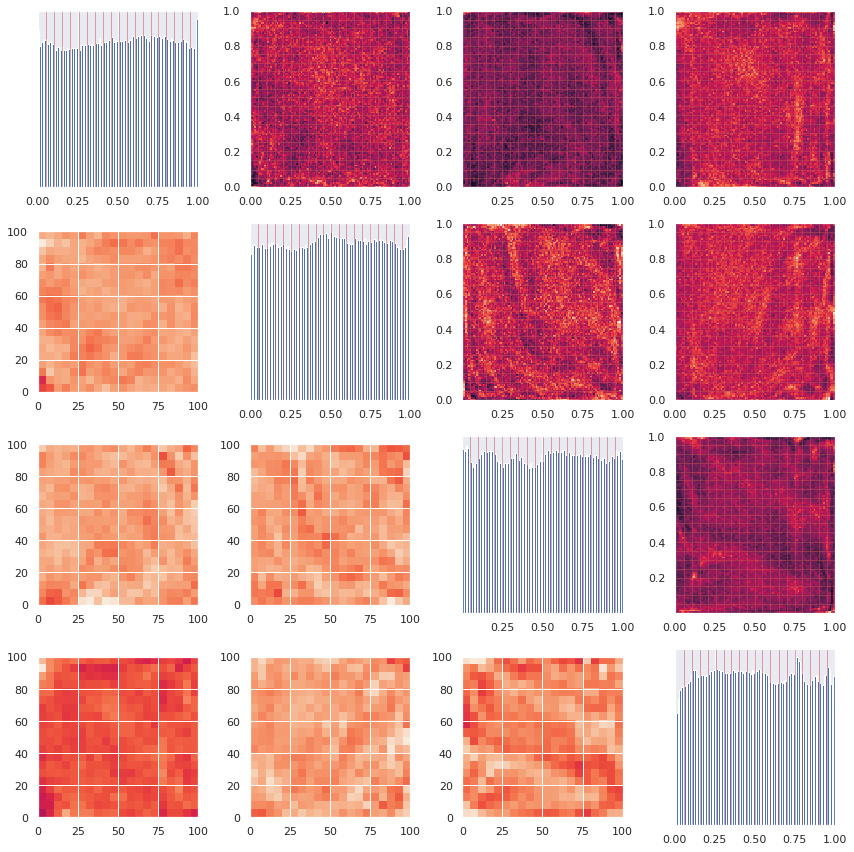

In [21]:
plotfbins(U_dc2, inset_pct=0)

In [26]:
def group_and_plot(U, Y, zedges, npct=10, ngrps=400):
    group.groupbins(U, Y, zedges, npct=npct, method='weighted', sigma=0.2,
              ngrp_save=(400, 300, 200, 150, 100, 75), maxfrac=0.02, minfrac=0.005,
              validate=False, validate_interval=1000, maxiter=None,
              plot_interval=None, savename='group_{N}.npz')
    grps = np.load(f'group_{ngrps}.npz')
    zhist = grps['zhist']
    group.plotzgrp(zhist, zedges, sort=True)    

In [1]:
group_and_plot(U_dc2, Y_dc2, zedges=zedges)

NameError: name 'group_and_plot' is not defined

#### Run on Buzzard data set

In [19]:
thin = 10
X = buzzard_train[::thin]
Y = buzzard_train_z[::thin]

In [20]:
len(X)

541018

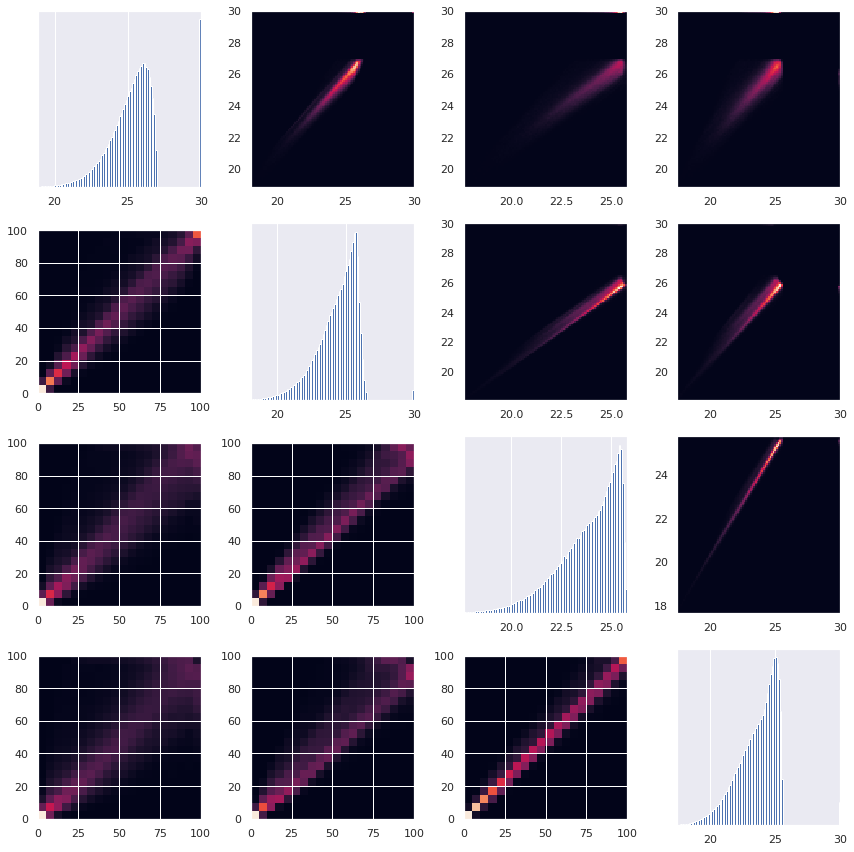

In [21]:
plotfbins(X, inset_pct=0.1, show_edges=False)

Found 31387 galaxies with undetected flux in at least one band.
epoch 25 loss -1.227


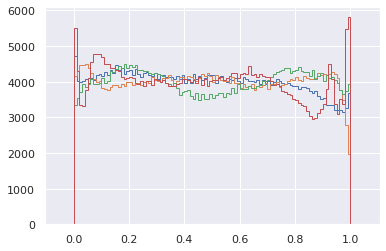

epoch 50 loss -1.290


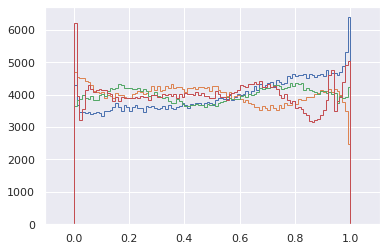

epoch 75 loss -1.296


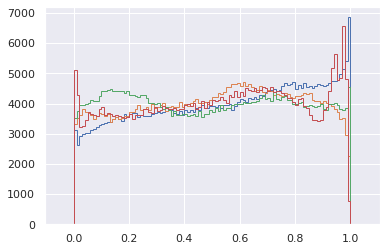

epoch 100 loss -1.309


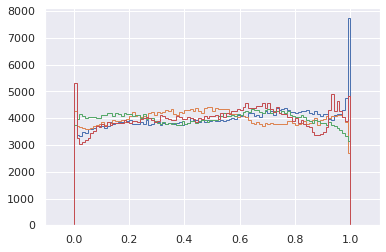

epoch 125 loss -1.295


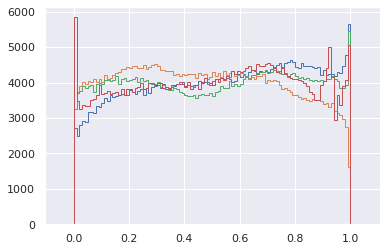

epoch 150 loss -1.413


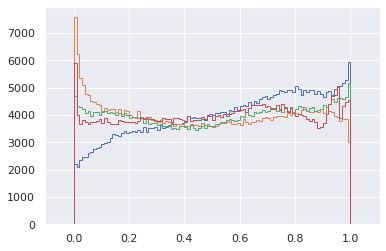

epoch 175 loss -1.333


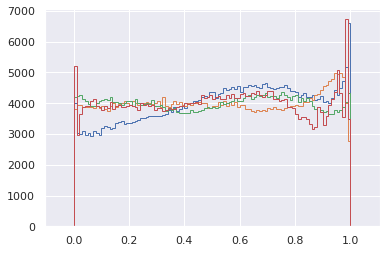

epoch 200 loss -1.376


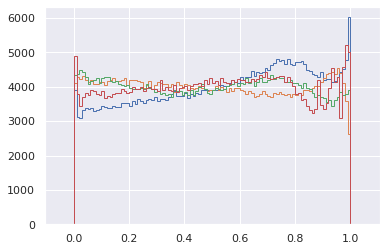

Finished in 396.6460859775543 seconds


In [22]:
U_buzz, X_buzz, Y_buzz = preprocess(X, Y, bands='griz')

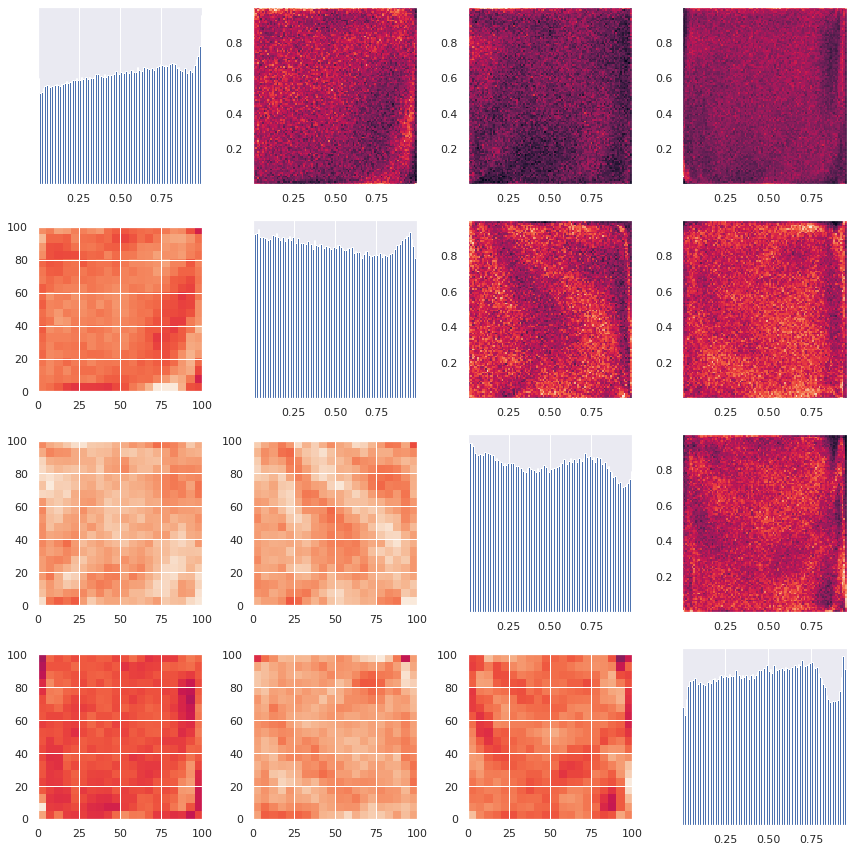

In [24]:
plotfbins(U_buzz, inset_pct=0.1, show_edges=False)

In [ ]:
group_and_plot(U_buzz, Y_buzz, zedges=zedges)

Grouping with ndata=509631, nmin=2548, nmax=10193, nzbin=80, nfbin=10000.


#### Run on similar features to those Angus used

- g-r, g-i, g-z, r-i, r-z, i-z, z, g-r-(r-i), r-i-(i-z)

In [8]:
features, detected = prepare(dc2_train, bands, useflux='i')
fluxes = dc2_train[detected]
redshifts = dc2_train_z[detected]

Found 491827 galaxies with undetected flux in at least one band.


In [221]:
# from: https://github.com/dkirkby/zotbin/blob/master/zotbin/util.py

def prepare(data, bands, feature_mode='i'):
    """Prepare features from input data and flag galaxies with undetected flux.
    """
    if data.shape[1] != len(bands):
        raise ValueError(f'data has {data.shape[1]} columns but expected {len(bands)} for {bands}.')
    # Flag any galaxies with undetected flux.
    detected = np.all((data != 30) & np.isfinite(data), axis=1)
    print(f'Found {np.count_nonzero(~detected)} galaxies with undetected flux in at least one band.')
        
    if feature_mode in 'griz':
        # Use colors plus one flux as the input features.
        colors = np.diff(data, axis=1)
        idx = bands.index(feature_mode)
        flux = data[:, idx:idx+1]
        features = np.concatenate((colors, flux), axis=1)
        return features, detected
        
    if feature_mode == 'triplets':
        df = pd.DataFrame()
        # colors
        for i in range(len(bands)-1):
            for j in range(i+1, len(bands)):
                col = f'{bands[i]}-{bands[j]}'
                df[col] = data[:,i] - data[:,j]

        # triplets
        for i in range(len(bands)-2):
            color1 = f'{bands[i]}-{bands[i+1]}'
            color2 = f'{bands[i+1]}-{bands[i+2]}'
            col = f'{color1}-({color2})'
            df[col] = df[color1] - df[color2]

        # z flux
        col = 'z'
        df[col] = data[:,-1]
        return(df.to_numpy(), detected)

In [226]:
features, detected = prepare(dc2_train, bands='griz', feature_mode='triplets')

Found 491827 galaxies with undetected flux in at least one band.


In [10]:
features = prepare_features(fluxes)
features = features.to_numpy()

In [11]:
thin = 10

X = features[::thin]
Y = redshifts[::thin]

#### Run SOM

In [21]:
nside = -20
niter = 20

In [22]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
som_train.fit(X, Y, maxiter=niter)
print(time.time() - start)

1353.3029963970184


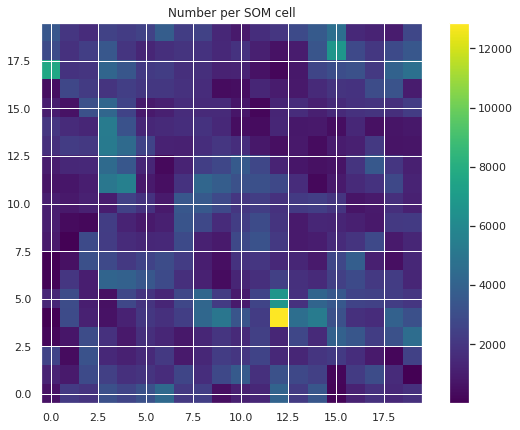

In [24]:
som_train.plot_counts_per_cell()

In [25]:
np.min(som_train._counts)

1

In [26]:
ngrp = nside ** 2
nzbin = 80

zedges = binned.get_zedges(zmax=3, nzbin=nzbin)

In [27]:
zhist = np.empty((ngrp,nzbin))

for i in range(ngrp):
    zhist[i], _ = np.histogram(som_train._target_dist[i], bins=nzbin)

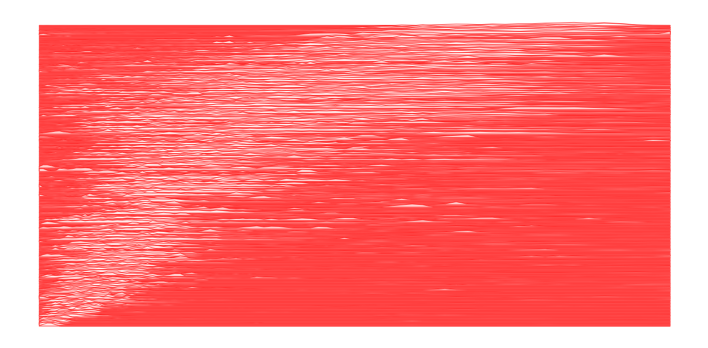

In [28]:
group.plotzgrp(zhist, zedges, sort=True)

### Run zotbin

epoch 25 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

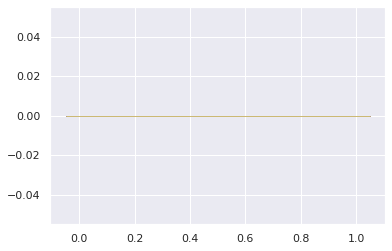

epoch 50 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

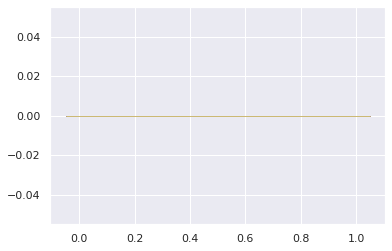

epoch 75 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

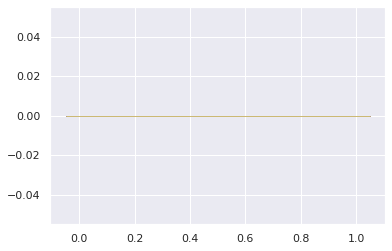

epoch 100 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

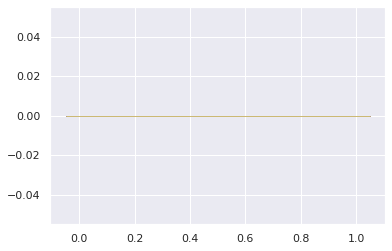

epoch 125 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

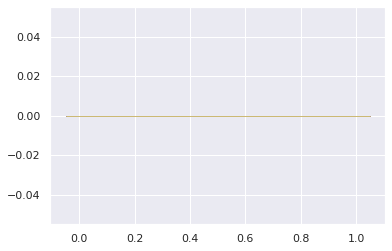

epoch 150 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

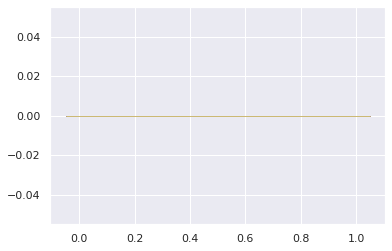

epoch 175 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

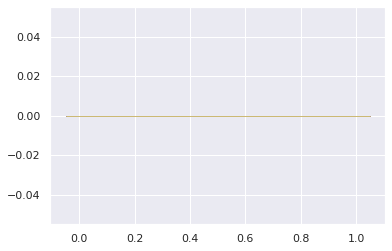

epoch 200 loss nan


/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6620: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/global/homes/b/belaa/.conda/envs/pz_bayes/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6621: RuntimeW

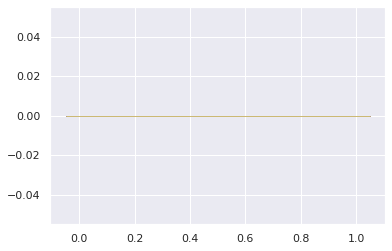

Finished in 457.42381143569946 seconds


In [31]:
U_dc2, X_dc2, Y_dc2 = preprocess(X, Y, bands=None)

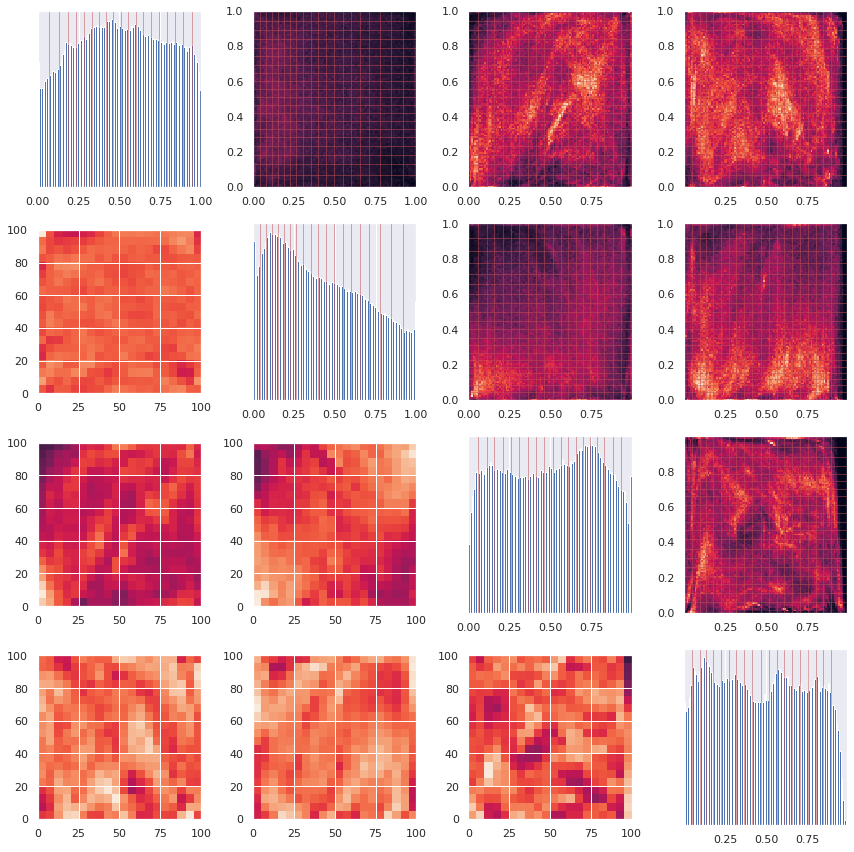

In [37]:
plotfbins(U_dc2, inset_pct=0)